In [2]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [3]:
from common import *
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import cm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.random_projection import GaussianRandomProjection

In [4]:
np.random.seed(0)

In [5]:
import warnings; warnings.simplefilter('ignore')

In [6]:
# Dataset Phone Price
x_train, x_test, y_train, y_test = read_dataset(path_to_file="../Data/dataset2/train.csv")

In [7]:
y_test[y_test<=1] = 0
y_test[y_test>=2] = 1
y_train[y_train<=1] = 0
y_train[y_train>=2] = 1

In [8]:
# preventing information about the distribution of the test set leaking into your model
standard_scaler = MinMaxScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.fit_transform(x_test)

In [19]:
rc_errors = {}
for dim in range(2, 50):
    grp = GaussianRandomProjection(n_components=dim, random_state=0)
    x_prime = grp.fit_transform(x_train_scaled)
    
    # reconstruction
    A = np.linalg.pinv(grp.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(x_train.values, reconstructed)    
    rc_errors[dim] = rc_err

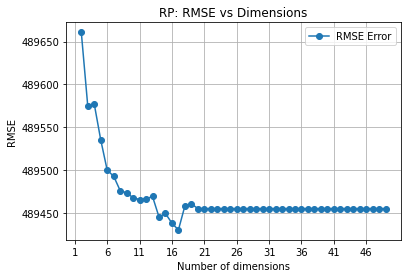

In [97]:
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()), 'o-')
plt.title("RP: RMSE vs Dimensions")
plt.xlabel("Number of dimensions")
plt.ylabel("RMSE")
plt.grid()
plt.legend(["RMSE Error"])
plt.xticks(np.arange(1, len(rc_errors), 5))
plt.show()

In [23]:
comp = 17
grp = GaussianRandomProjection(n_components=comp, random_state=0)
grp_result = grp.fit_transform(x_train_scaled)
for i in range(comp):
    field_name = "grp-"+str(i)
    x_train[f"grp-{i}"] = grp_result[:,i]
y_train

,price_range
1520,1
64,1
1431,1
926,0
983,0
...,...
1937,1
1818,0
724,0
1160,1


<AxesSubplot:xlabel='grp-1', ylabel='grp-2'>

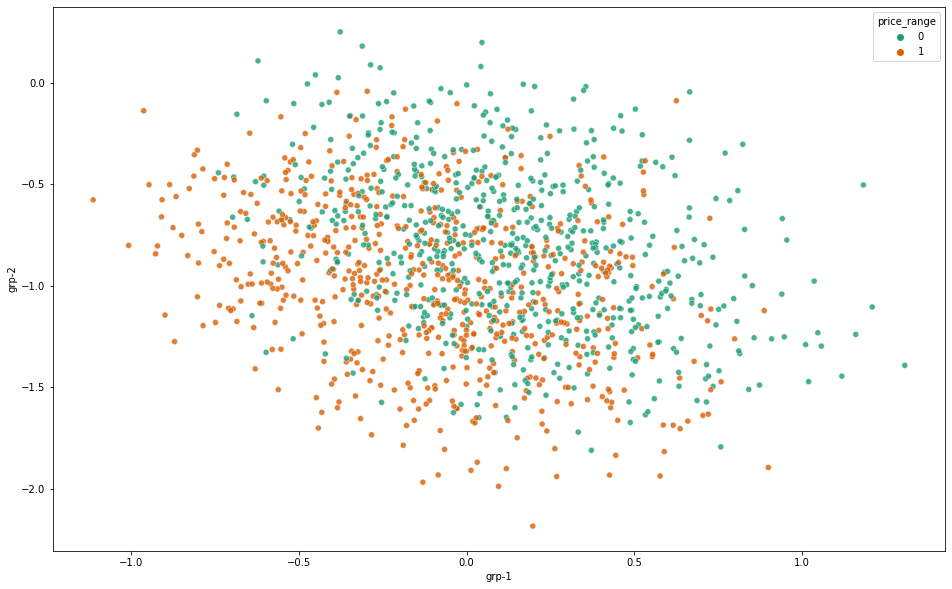

In [71]:
x_train['price_range'] = y_train['price_range']
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="grp-1", y="grp-2",
    hue="price_range",
    palette=sns.color_palette("Dark2", 2),
    data=x_train,
    legend="full",
    alpha=0.8
)

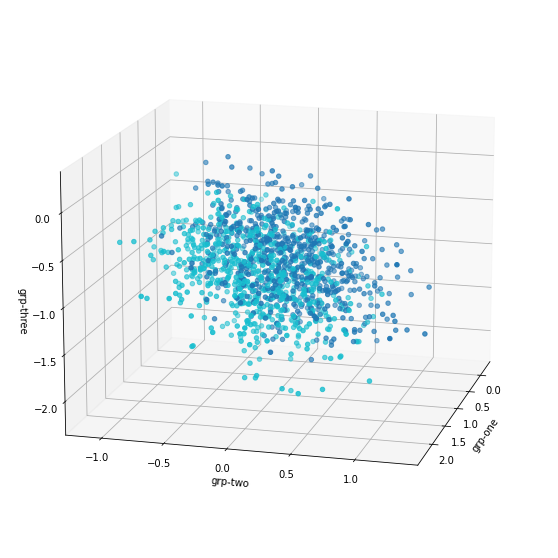

In [70]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=x_train["grp-0"], 
    ys=x_train["grp-1"], 
    zs=x_train["grp-2"], 
    c=x_train["price_range"], 
    cmap='tab10'
)
ax.set_xlabel('grp-one')
ax.set_ylabel('grp-two')
ax.set_zlabel('grp-three')
ax.view_init(15, 15)
plt.show()

In [37]:
s = {}
h = {}
clusters = range(2, 25)
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=0, n_jobs=-1).fit(grp_result)
    label = kmeans.labels_
    s[cluster] = silhouette_score(grp_result, label, metric='euclidean')
    h[cluster] = homogeneity_score(y_train['price_range'].values, label)

In [38]:
sdf = pd.DataFrame(list(s.values()), columns=['Silhouette'])
sdf['Homogeneity'] = pd.DataFrame(list(h.values()))

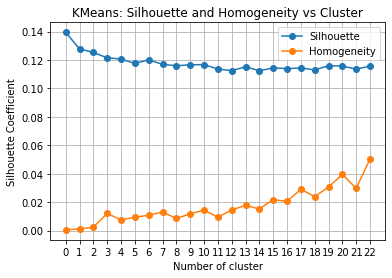

In [95]:
plt.figure()
plt.title("KMeans: Silhouette and Homogeneity vs Cluster")
plt.plot(sdf, 'o-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.grid()
plt.legend(sdf.columns)
plt.xticks(range(sdf.shape[0]))
plt.show()

In [82]:
s_EM = {}
h_EM = {}
log_likelihood_EM = {}
clusters = range(2, 25)
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=0, n_init=50).fit(grp_result)
    label = gmm.predict(grp_result)
    s_EM[cluster] = silhouette_score(grp_result, label, metric='euclidean')
    h_EM[cluster] = homogeneity_score(y_train['price_range'].values, label)
    log_likelihood_EM[cluster] = gmm.score(grp_result)

In [87]:
gdf = pd.DataFrame(list(s_EM.values()), columns=['Silhouette'])
gdf['Homogeneity'] = pd.DataFrame(list(h_EM.values()))
gdf['Likelihood'] = pd.DataFrame(list(log_likelihood_EM.values()))

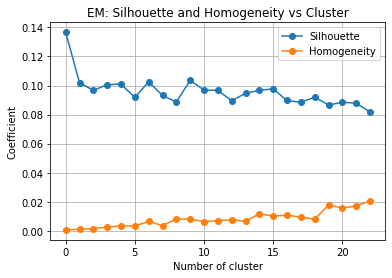

In [94]:
plt.figure()
plt.title("EM: Silhouette and Homogeneity vs Cluster")
plt.plot(gdf[['Silhouette', 'Homogeneity']], 'o-')
plt.xlabel("Number of cluster")
plt.ylabel("Coefficient")
plt.grid()
plt.legend(['Silhouette', 'Homogeneity'])
plt.show()

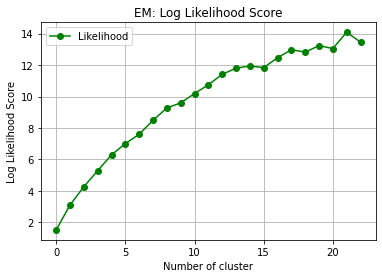

In [91]:
plt.figure()
plt.title("EM: Log Likelihood Score")
plt.plot(gdf[['Likelihood']], 'o-', color="green")
plt.xlabel("Number of cluster")
plt.ylabel("Log Likelihood Score")
plt.grid()
plt.legend(['Likelihood'])
plt.show()

In [73]:
nn = MLPClassifier()
nn.fit(grp_result, y_train['price_range'].values)

MLPClassifier()

In [74]:
y_pred = nn.predict(grp_result)
accuracy = accuracy_score(y_train, y_pred)
print(accuracy)
print(classification_report(y_train, y_pred))

0.931060606060606
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       660
           1       0.93      0.93      0.93       660

    accuracy                           0.93      1320
   macro avg       0.93      0.93      0.93      1320
weighted avg       0.93      0.93      0.93      1320



In [75]:
grp_result.shape

(1320, 17)

In [76]:
x_train.shape

(1320, 38)

In [81]:
print(f"Intial Features #: {x_train.shape[1]} ")
print(f"Reduced Feature #: {grp_result.shape[1]}")
print(f"Difference Down % : {(38 - 17) / 38}")

Intial Features #: 38 
Reduced Feature #: 17
Difference Down % : 0.5526315789473685
